In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('breast_cancer_data.csv')

In [3]:
df = df.drop('Unnamed: 32', axis = 1)
df = df.drop('id', axis = 1)

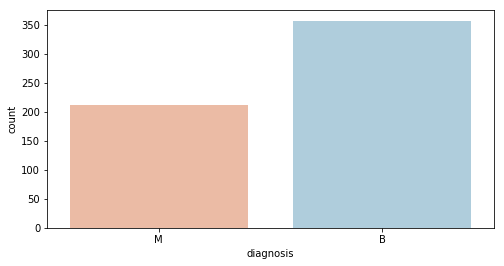

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(df['diagnosis'], palette='RdBu')

As we can see, there are more records in our data that are marked B (benign) than M (malignant). This problem is called `class-imbalance` in Machine Learning. Most real-world classification problems display some level of class imbalance, which is when each class does not make up an equal portion of your data-set. It is important to properly adjust your metrics and methods to adjust for your goals. If this is not done, you may end up optimizing for a meaningless metric in the context of your use case. 

For example, suppose you have two classes — A and B. Class A is 90% of your data-set and class B is the other 10%, but you are most interested in identifying instances of class B. You can reach an accuracy of 90% by simply predicting class A every time, but this provides a useless classifier for your intended use case. Hence, instead of using just Accuracy like we did in the previous notebook, we will also introduce other metrics like `Area Under Precision Recall Curve`, `F1 score`, etc. We will explain what they mean along the way.

# Feature Selection

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.
    
We saw some classification models in the previous notebook and we noticed that the accuracy on train data is higher than that on test data. This problem was specially extreme in the `SVM` model where train accuracy was `100%` but test accuracy was just around `61%`. This problem is called `overfitting` where the model learns to fit on the noises of the training data and fails to generalize. This leads to low performance on held out/ test data.

Feature selection helps us in two ways: 
1. Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
2. Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

Here, we demonstrate 2 ways to do feature selection.
1. Correlation matrix heatmap
2. Feature importance

### 1. Correlation Matrix Heatmap 

Correlation matrix shows how the features are related to each other. If two or more features are highly correlated to each other, we can just keep one and drop the rest as they are redundant.

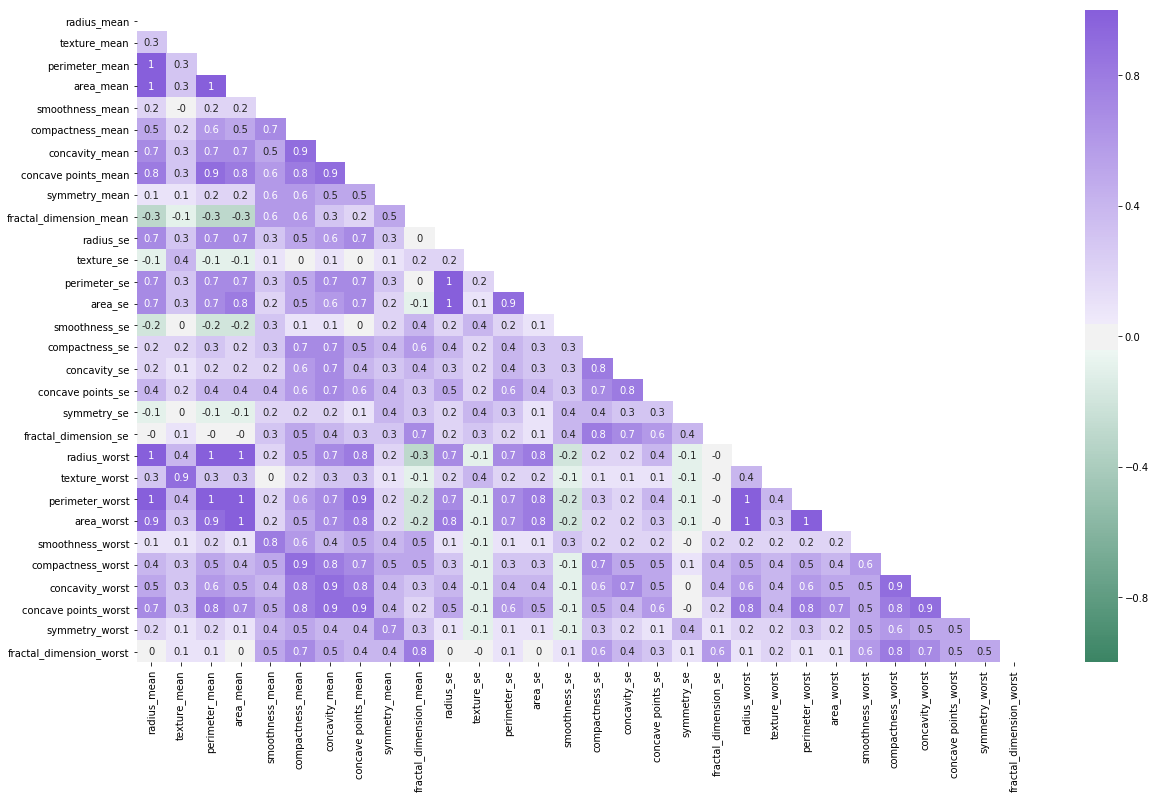

In [5]:
corr_matrix = df.corr().round(1)
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,12))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask, annot=True, cmap= cmap, vmin=-1, vmax=1)

As we can see from the heatmap, the columns 'perimeter_mean', 'area_mean' and 'radius_mean' have a correlation of 1 with respect to each other. This is essentially because all of them give only information about the size of the cells.

Since, this leads to duplication of features which does not add any value to the information needed for classification. Hence, we only have to consider one of them for our classification task and can drop the others from the dataframe.

Same thing can be observed with radius_se, perimeter_se and area_se. Hence, we can drop the two of them.

In [6]:
df = df.drop('perimeter_mean', axis = 1)
df = df.drop('area_mean', axis = 1)
df = df.drop('perimeter_se', axis = 1)
df = df.drop('area_se', axis = 1)

Drawing the heatmap again with new correlation matrix

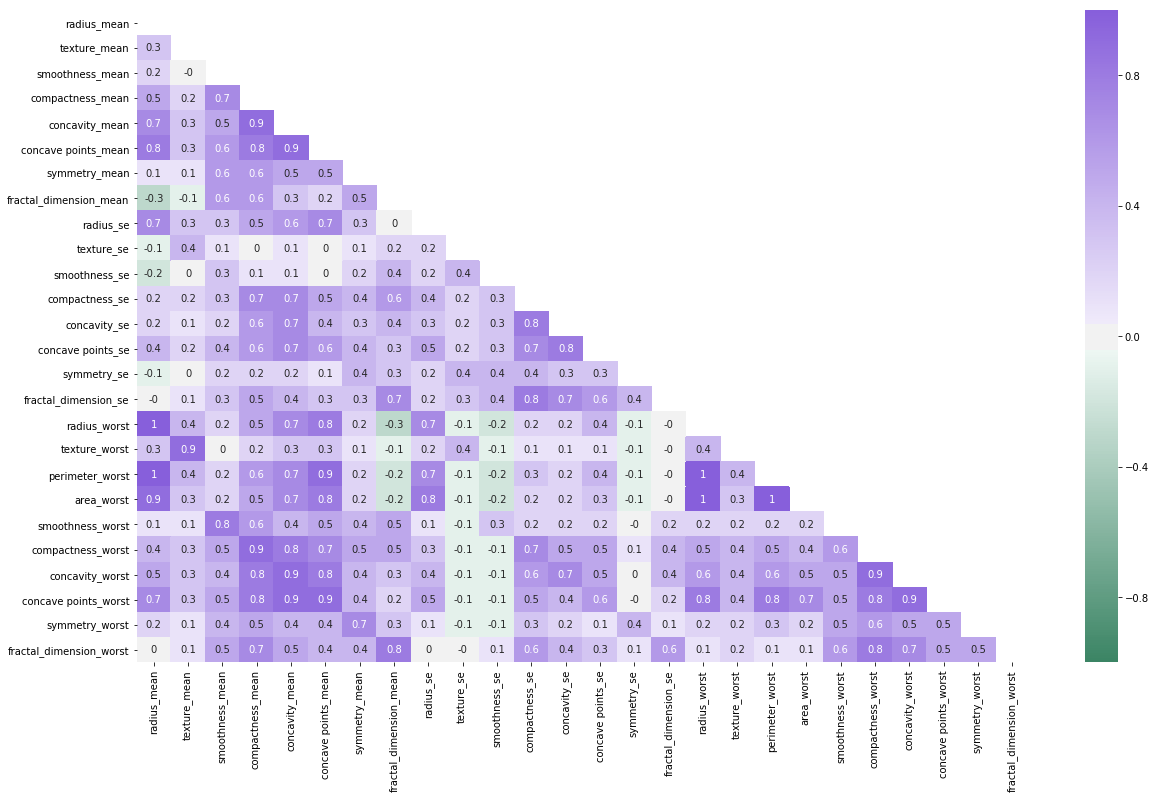

In [7]:
corr_matrix = df.corr().round(1)
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,12))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask, annot=True, cmap= cmap, vmin=-1, vmax=1)

Again we see that, there is a very strong correlation between radius_mean, radius_worst, perimeter-worst and area_worst. And hence, all these can also be removed. Infact, all attributes with worst columns have a strong correlation with their mean counterparts. Hence, we drop all of them.

In [8]:
cols_to_drop = ['radius_worst', 
        'texture_worst', 
        'perimeter_worst', 
        'area_worst', 
        'smoothness_worst', 
        'compactness_worst', 
        'concavity_worst',
        'concave points_worst', 
        'symmetry_worst', 
        'fractal_dimension_worst']

df = df.drop(cols_to_drop, axis = 1)

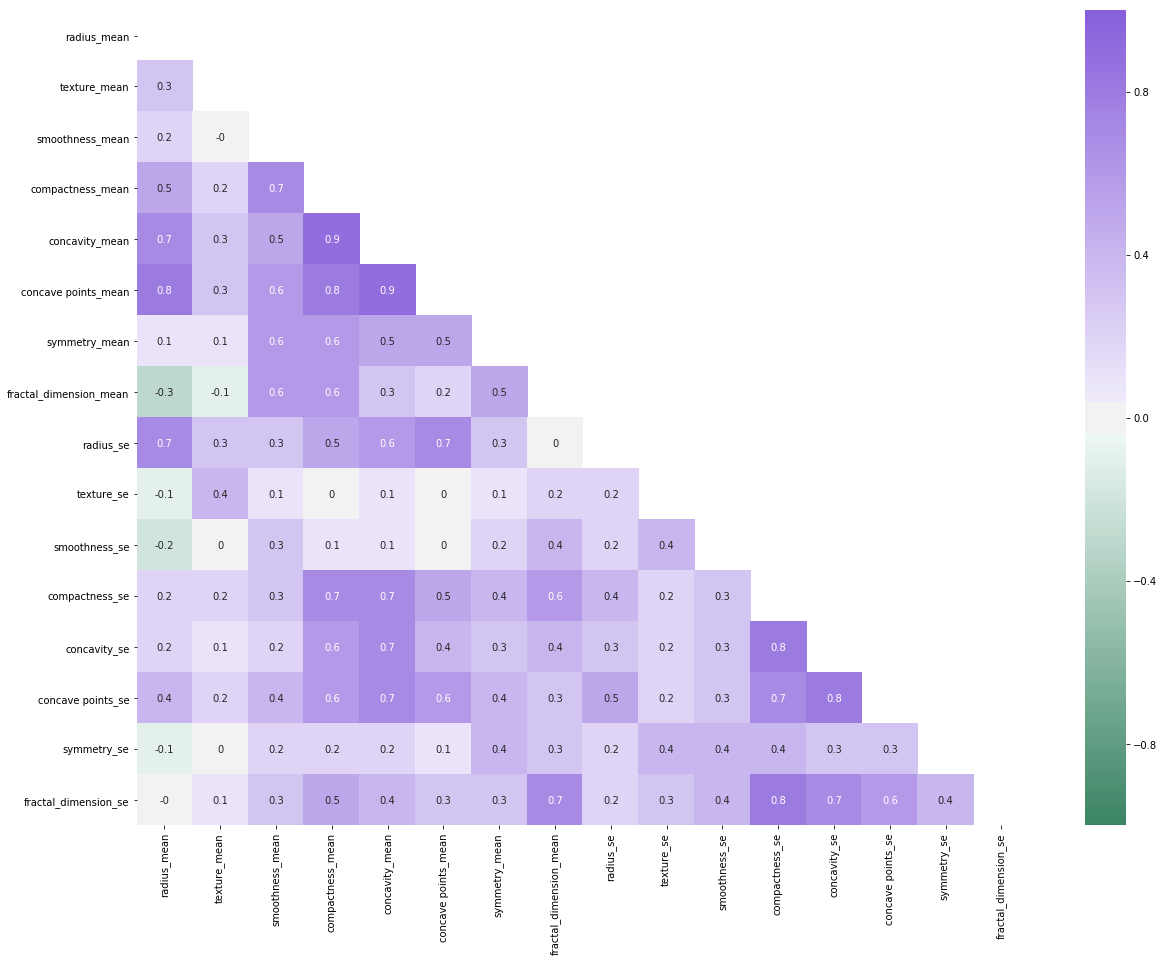

In [9]:
corr_matrix = df.corr().round(1)
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask, annot=True, cmap= cmap, vmin=-1, vmax=1)

Now, when we observe the heatmap, we again observe a strong correlation between attributes related to compactness, concavity and concave_points. So, we will only consider one of them.

In [10]:
cols_to_drop = ['concavity_mean',
                'concavity_se',
                'concave points_mean', 
                'concave points_se']
df = df.drop(cols_to_drop, axis=1)

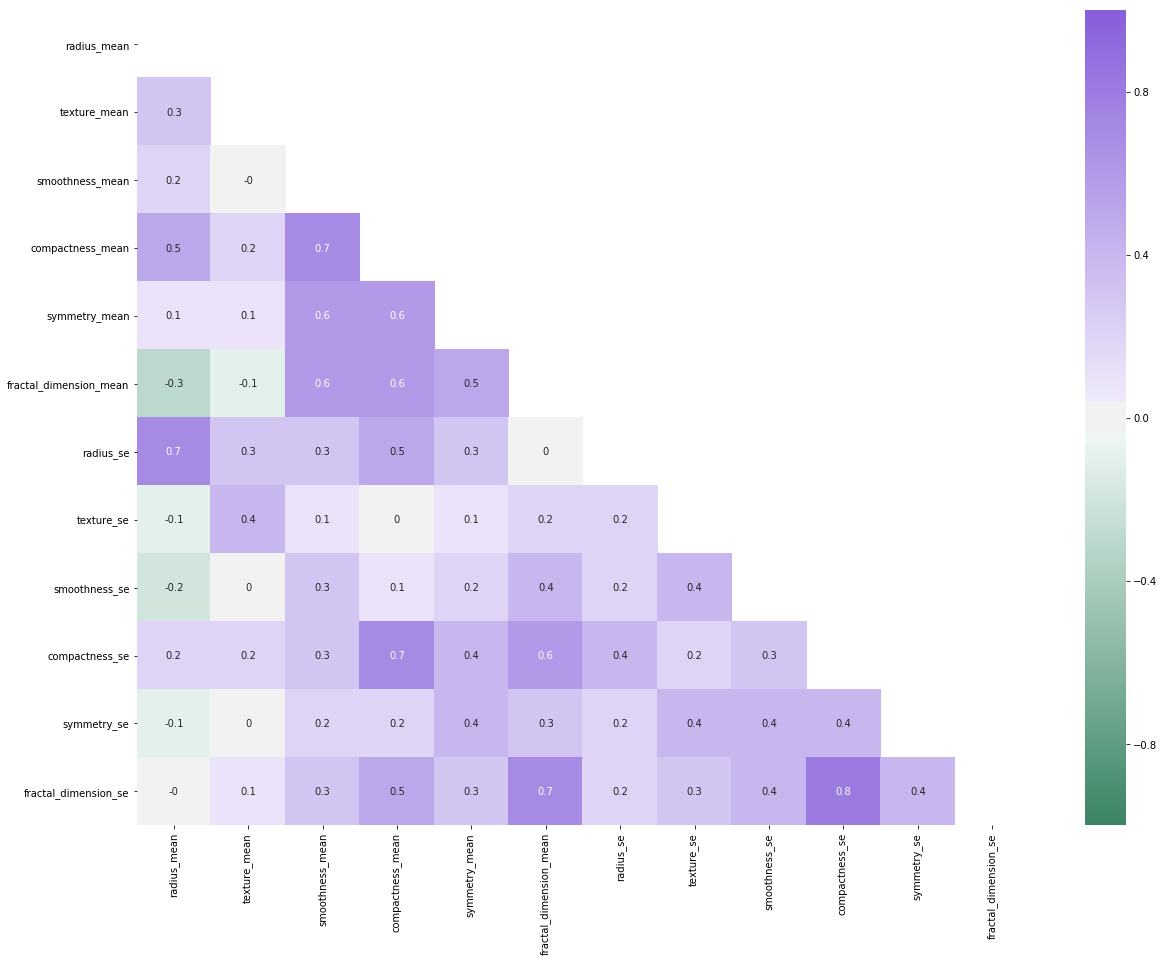

In [11]:
corr_matrix = df.corr().round(1)
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(150, 275, as_cmap=True)
sns.heatmap(corr_matrix, mask = mask, annot=True, cmap= cmap, vmin=-1, vmax=1)

We use these remaining features and test our classification performance. We demonstrate two metrics here to test performance of the model: Accuracy and F-1 score. 

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
```
F1 = 2 * (precision * recall) / (precision + recall)
```

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import f1_score

In [13]:
#we generate labels, denoted by Y (diagnosis column) and the rest of the data will be denoted by X
labels = df['diagnosis']
Y = [1 if ele == "M" else 0 for ele in labels] #convert labels M and B to binary(1 and 0)
df = df.drop('diagnosis', axis=1)#drop the diagnosis column from the dataframe

In [14]:
X = df

#splitting data into train and test
#this is done to test on samples that the model has not been trained on, it leads to less bias
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

### SVM Classifier

In [15]:
clf_svm = svm.SVC().fit(X_train, Y_train)
Y_predicted_svm_train = clf_svm.predict(X_train)
Y_predicted_svm = clf_svm.predict(X_test)
svm_accuracy = np.logical_xor(Y_predicted_svm, Y_test)
svm_accuracy = np.logical_not(svm_accuracy)
print("Train accuracy: ",clf_svm.score(X_train, Y_train))
print("Test accuracy: ",clf_svm.score(X_test, Y_test))
print("Train F-1 score: ", f1_score(Y_train, Y_predicted_svm_train))
print("Test F-1 score: ", f1_score(Y_test, Y_predicted_svm))
svm_accuracy_int_all_feat = [1 if ele == True else 0 for ele in svm_accuracy]

Train accuracy:  0.9098901098901099
Test accuracy:  0.9122807017543859
Train F-1 score:  0.8746177370030581
Test F-1 score:  0.8648648648648648


We see a clear boost in the performace of SVM by removal of redundant features. This demonstrates the importance of feature selection.

Additionally, we also see how F-1 score is lower than Accuracy proving that there is some class imbalance in data which was effecting the model accuracy numbers to mislead.

### 2. Feature importance

In this section, we check whether removing fetures increases or decreases the performace of the model based on which we decide whether to keep the features or drop them.

In [16]:
list(df)

['radius_mean',
 'texture_mean',
 'smoothness_mean',
 'compactness_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'smoothness_se',
 'compactness_se',
 'symmetry_se',
 'fractal_dimension_se']

As we can see, there are two types of features in the data: `_mean` and `_se`. We remove one type at a time and see how that effects the accuracy. 

In [17]:
cols_to_drop_for_mean = ['radius_se',
                'texture_se',
                'smoothness_se',
                'compactness_se',
                'symmetry_se',
                'fractal_dimension_se']

In [18]:
df_just_mean = df.drop(cols_to_drop_for_mean, axis = 1)

In [19]:
X_just_mean = df_just_mean

#splitting data into train and test
#this is done to test on samples that the model has not been trained on, it leads to less bias
X_train, X_test, Y_train, Y_test = train_test_split(X_just_mean, Y, test_size = 0.2)

In [20]:
clf_svm = svm.SVC().fit(X_train, Y_train)
Y_predicted_svm_train = clf_svm.predict(X_train)
Y_predicted_svm = clf_svm.predict(X_test)
svm_accuracy = np.logical_xor(Y_predicted_svm, Y_test)
svm_accuracy = np.logical_not(svm_accuracy)
print("Train accuracy: ",clf_svm.score(X_train, Y_train))
print("Test accuracy: ",clf_svm.score(X_test, Y_test))
print("Train F-1 score: ", f1_score(Y_train, Y_predicted_svm_train))
print("Test F-1 score: ", f1_score(Y_test, Y_predicted_svm))
svm_accuracy_int_just_mean = [1 if ele == True else 0 for ele in svm_accuracy]

Train accuracy:  0.9142857142857143
Test accuracy:  0.8859649122807017
Train F-1 score:  0.8785046728971964
Test F-1 score:  0.8505747126436782


In [21]:
cols_to_drop_for_se = ['radius_mean',
                          'texture_mean',
                          'smoothness_mean',
                          'compactness_mean',
                          'symmetry_mean',
                          'fractal_dimension_mean']

In [22]:
df_just_se = df.drop(cols_to_drop_for_se, axis = 1)

In [23]:
X_just_se = df_just_se

#splitting data into train and test
#this is done to test on samples that the model has not been trained on, it leads to less bias
X_train, X_test, Y_train, Y_test = train_test_split(X_just_se, Y, test_size = 0.2)

In [24]:
clf_svm = svm.SVC().fit(X_train, Y_train)
Y_predicted_svm_train = clf_svm.predict(X_train)
Y_predicted_svm = clf_svm.predict(X_test)
svm_accuracy = np.logical_xor(Y_predicted_svm, Y_test)
svm_accuracy = np.logical_not(svm_accuracy)
print("Train accuracy: ",clf_svm.score(X_train, Y_train))
print("Test accuracy: ",clf_svm.score(X_test, Y_test))
print("Train F-1 score: ", f1_score(Y_train, Y_predicted_svm_train))
print("Test F-1 score: ", f1_score(Y_test, Y_predicted_svm))
svm_accuracy_int_just_se = [1 if ele == True else 0 for ele in svm_accuracy]

Train accuracy:  0.778021978021978
Test accuracy:  0.8771929824561403
Train F-1 score:  0.6130268199233717
Test F-1 score:  0.7941176470588235


We can see that using just SE features performes very poorly. Hence, we should keep the `_mean` features. 

In order to decide whether to keep the `_se` features or not, we do a p-test. This is because even though the F-1 score is different but it is not clear whether this happened by chance or is actually significant. 

In [25]:
# Pseudocode:
#
# 1. Measure the difference between the two group means.  The difference in means is measured
#    by (sum(grpA) / len(grpA)) - (sum(grpB) / len(grpB)).  
#
# 2. Set a counter to 0, this will count the number of times we get a difference
#    between the means greater than or equal to the original(calculated in step 1).  
#
# 3. Do the following 10,000 times:
#    a. Shuffle the original measurements.  To do this:
#       i. put the values from all the groups into one array but remembering the start and end indexes of each group
#       ii. shuffle the values in the array, effectively reassigning the values to different groups
#    b. Measure the difference between the two group means, just as we did in step (1).
#    c. If the difference from step (3b) is greater than or equal to the difference calculated in step 1, increment our counter 
#       from step (2). Note: if our original difference between the means were a negative value 
#       we would check for values less than or equal to that value.
#
# 4. counter / 10,000 equals the probability of getting our observed difference of two means greater than
#    or equal to 12.97, if there is in fact no significant difference.

import random

def shuffle(grps):
    num_grps = len(grps)
    pool = []

    # pool all values
    for i in range(num_grps):
        pool.extend(grps[i])
    # mix them up
    random.shuffle(pool)
    # reassign to groups of same size as original groups
    new_grps = []
    start_index = 0
    end_index = 0
    for i in range(num_grps):
        end_index = start_index + len(grps[i])
        new_grps.append(pool[start_index:end_index])
        start_index = end_index
    return new_grps

# subtracts group a mean from group b mean and returns result
def meandiff(grpA, grpB):
    return sum(grpB) / float(len(grpB)) - sum(grpA) / float(len(grpA))

def p_test(samples):
    a = 0
    b = 1
    observed_mean_diff = meandiff(samples[a], samples[b])
    

    count = 0
    num_shuffles = 10000
    for i in range(num_shuffles):
        new_samples = shuffle(samples)
        mean_diff = meandiff(new_samples[a], new_samples[b])
        # if the observed difference is negative, look for differences that are smaller
        # if the observed difference is positive, look for differences that are greater
        if observed_mean_diff < 0 and mean_diff <= observed_mean_diff:
            count = count + 1
        elif observed_mean_diff >= 0 and mean_diff >= observed_mean_diff:
            count = count + 1
    ######################################
    #
    # Output
    #
    ######################################

    print ("Observed difference of two means: %.2f" % observed_mean_diff)
    print (count, "out of", num_shuffles, "experiments had a difference of two means ", end="")
    if observed_mean_diff < 0:
        print ("less than or equal to ", end="")
    else:
        print ("greater than or equal to ", end=" ")
    print ("%.2f" % observed_mean_diff, ".")
    print ("The chance of getting a difference of two means", end=" ")
    if observed_mean_diff < 0:
        print ("less than or equal to ", end="")
    else:
        print ("greater than or equal to ", end="")
    print ("%.2f" % observed_mean_diff, "is", (count / float(num_shuffles)), ".")

In [26]:
samples = []
samples.append(svm_accuracy_int_all_feat)
samples.append(svm_accuracy_int_just_mean)
p_test(samples)

Observed difference of two means: -0.03
3371 out of 10000 experiments had a difference of two means less than or equal to -0.03 .
The chance of getting a difference of two means less than or equal to -0.03 is 0.3371 .


As we can see, the difference is not significant, we can either decide to keep or remove the `_se` features. In the interest of reducing the dimensionality of data, we can remove the features.